In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

### Credit Value Adjustment

You have a portfolio of interest rate swaps (note that two of them are off-market swaps, meaning that
they have a value different from zero at initiation):

• A 10-year interest swap on a notional of $2 million, where you pay a fixed swap rate of 2?\% and
receive the floating rate

• A 7-year interest swap on a notional of $8 million, where you pay a fixed swap rate set such that
the initial value of the contract is zero and receive the floating rate

• A 4-year interest swap on a notional of $6 million dollars, where you pay the floating rate and
receive a fixed rate of 3\%

All swap payments are made on a quarterly basis, and you believe that the evolution of the interest
rate can be described using a Vasicek4 model estimated from data uploaded on Learn.

The interest rate swaps are entered with Credit Suisse, and their creditworthiness can be evaluated using
the following CDS spreads along with an assumption that R = 32%.

### Interest rate model

Estimate the parameters in the Vasicek model using the uploaded data. The data is simulated for the
purpose of this project and can be seen as daily observed data for five years.

This was uploaded as xsxl. The parameters we obtained are:

    a = -0.003
    b = 0.031
    sigma = 0.00096

### Calculation of exposure

For each of the swap contracts, use interest rate simulations to calculate the future values of the interest
swaps. Use these simulated values to find the expected exposure, the peak exposure (97.5%), and the
maximum peak exposure.

In [8]:
df = pd.read_excel("RatesComma.xlsx")

In [6]:
def simulate_Vasicek_One_Factor(r0: float = 0.1, a: float = 1.0, lam: float = 0.1, sigma: float = 0.2, T: int = 52, dt = 0.1) -> pd.DataFrame:
    # SIMULATE_VASICEK_ONE_FACTOR simulates a temporal series of interest rates using the One Factor Vasicek model
    # interest_rate_simulation = simulate_Vasicek_One_Factor(r0, a, lam, sigma, T, dt)
    #
    # Arguments:
    #   r0    = float, starting interest rate of the vasicek process 
    #   a     = float, speed of reversion" parameter that characterizes the velocity at which such trajectories will regroup around b in time
    #   lam   = float, long term mean level that all future trajectories will evolve around  
    #   sigma = float, instantaneous volatility measures instant by instant the amplitude of randomness entering the system
    #   T     = integer, end modelling time. From 0 to T the time series runs. 
    #   dt    = float, increment of time that the proces runs on. Ex. dt = 0.1 then the time series is 0, 0.1, 0.2,...
    #
    # Returns:
    #   interest_rate_simulation = N x 2 pandas DataFrame where index is modeling time and values are a realisation of the uderlying's price
    #
    # Example:
    #   Model the interest rate which is 10% today. The annualized instant volatility is 20%. The external analysis points out that the mean reversion parameter is 1 and the long term interest rate level is 10 % therefore the mean reversion correction is theta = 10% * 1 = 10%. The user is interested in an interest rate projection of the next 10 years in increments of 6 months (0.5 years)
    #
    #   import pandas as pd
    #   import numpy as np
    #
    #   simulate_Vasicek_One_Factor(0.1, 1.0, 0.1, 0.2, 10, 0.5)   
    #   [out] = Time    Stock Price                
    #           0.000000        0.100000
    #           0.526316        0.212055
    #           1.052632        0.115934
    #           1.578947        0.012870
    #           2.105263        0.003295
    #           2.631579        0.206635
    #           3.157895        0.191319
    #           3.684211        0.108299
    #           4.210526        0.094983
    #           4.736842        0.075903
    #           5.263158        0.229143
    #           5.789474       -0.111977
    #           6.315789        0.120245
    #           6.842105        0.116082
    #           7.368421        0.230879
    #           7.894737        0.266821
    #           8.421053        0.229788
    #           8.947368        0.304378
    #           9.473684        0.217760
    #           10.000000       0.217147
    # For more information see https://en.wikipedia.org/wiki/Vasicek_model
    
    N = int(T / dt) # number of subintervals of length 1/dt between 0 and max modeling time T

    time, delta_t = np.linspace(0, T, num = N, retstep = True)

    r = np.ones(N) * r0

    for t in range(1,N):
        r[t] = r[t-1] * np.exp(-a*dt)+lam*(1-np.exp(-a*dt))+sigma*np.sqrt((1-np.exp(-2*a*dt))/(2*a))* np.random.normal(loc = 0,scale = 1)

    dict = {'Time' : time, 'Interest Rate' : r}

    interest_rate_simulation = pd.DataFrame.from_dict(data = dict)
    interest_rate_simulation.set_index('Time', inplace = True)

    return interest_rate_simulation

In [9]:
r0 = list(df["Group 2"])[-1]    # The starting interest rate
a = -0.003211481 # speed of reversion parameter
lam = 0.031008044 # long-term mean interest rate level correction
sigma = 0.0009 # instantaneous volatility
T = 252*10 # end modelling time
dt = 1 # increments of time

In [12]:
rates = list(simulate_Vasicek_One_Factor(r0, a, lam, sigma, T, dt)["Interest Rate"])

In [14]:
# Input data
SpotRate = 0.03;
k = 0.003;
theta = 0.03;
Vol = 0.0009;
SwapRate = 0.02; # pick your self or calculate at-market rate
TimeSteps = np.arange(0, 252, 1);
T = len(TimeSteps)-1;
PFE = []

In [15]:
K = 100

In [16]:
# This part is run many times
InterestRate = np.empty((T,K))
FloatingLeg = np.empty((T,K))
FixedLeg = np.empty((T,K))
SwapMtM = np.empty((T,K))

In [17]:
for m in range(K):
    # Simulate interest rates
    InterestRate[0,m] = SpotRate
    for i in range(1,T):
        InterestRate[i,m] = InterestRate[i-1,m] + k*(theta-InterestRate[i-1,m])*(TimeSteps[i]-TimeSteps[i-1])+np.random.standard_normal()*np.sqrt((TimeSteps[i]-TimeSteps[i-1]))*Vol


    B = (1-np.exp(-k*TimeSteps[1:T+1]))/k
    A = np.exp(((B-TimeSteps[1:T+1])*(k**2*theta-Vol**2/2))/k**2-(Vol**2*B**2/(4*k)))

    # Calculate discount factors to value swap
    DiscountFactors = np.full([T, T], np.nan)

    for i in range(T):
        DiscountFactors[:(T-i),i] = A[i]*np.exp(-InterestRate[:(T-i),m]*np.transpose(B[i]))

    FloatingLeg[:,m] = np.ones(T)-np.fliplr(DiscountFactors).diagonal()
    FixedLeg[:,m] = SwapRate*0.25*np.nansum(DiscountFactors, axis = 1)
    SwapMtM[:,m] = (FixedLeg[:,m]-FloatingLeg[:,m])

In [18]:
# Calculate exposure and 90% peak exposure
Exposure = SwapMtM*(SwapMtM>0);
EE = Exposure.mean(axis = 1)

for i in range(T):
    PFE.append(np.quantile(SwapMtM[i,:],0.9))

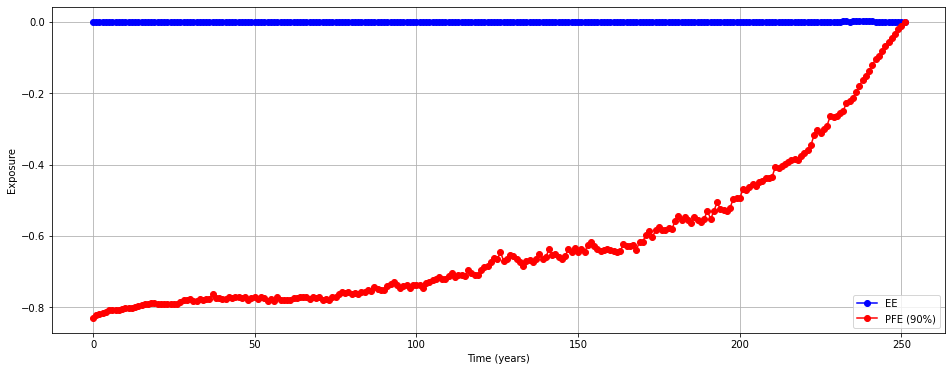

In [22]:
plt.figure(figsize = (16,6))
plt.plot(TimeSteps, np.append(EE, 0), '-bo', label = 'EE')
plt.plot(TimeSteps, np.append(PFE, 0), '-ro', label = 'PFE (90%)')
plt.xlabel('Time (years)')
plt.ylabel('Exposure')
plt.legend()
plt.grid()
plt.show()

In [23]:
# Vasicek model parameters from the excel file
a = -0.003211481  
lam = 0.031008044  
sigma = 0.0009  
T = 252*5  
dt = 1  
N = 1000  

# Swap contract details
contract_1_notional = 2000000
contract_1_fixed_rate = 0.02
contract_2_notional = 8000000
contract_3_notional = 6000000
contract_3_fixed_rate = 0.03

# Function to simulate interest rate paths using Vasicek model
def simulate_interest_rates():
    r = np.zeros((N, T))
    r[:, 0] = 0.03  # Initial interest rate
    for i in range(N):
        for t in range(1, T):
            epsilon = np.random.standard_normal()  # Standard normal random variable
            r[i, t] = r[i, t-1] + a * (lam - r[i, t-1]) * dt + sigma * np.sqrt(dt) * epsilon
    return r

# Function to calculate future values of swap contracts
def calculate_future_values(interest_rates):
    contract_1_future_values = []
    contract_2_future_values = []
    contract_3_future_values = []
    
    for i in range(N):
        contract_1_cash_flow = contract_1_notional * contract_1_fixed_rate * dt
        contract_1_present_value = contract_1_cash_flow / (1 + interest_rates[i, -1])
        contract_1_future_values.append(contract_1_present_value)
        
        contract_2_cash_flow = contract_2_notional * (interest_rates[i, -1] - interest_rates[i, 0]) / (1 + interest_rates[i, 0])
        contract_2_present_value = contract_2_cash_flow / (1 + interest_rates[i, -1])
        contract_2_future_values.append(contract_2_present_value)
        
        contract_3_cash_flow = contract_3_notional * contract_3_fixed_rate * dt
        contract_3_present_value = contract_3_cash_flow / (1 + interest_rates[i, -1])
        contract_3_future_values.append(contract_3_present_value)
    
    return np.array(contract_1_future_values), np.array(contract_2_future_values), np.array(contract_3_future_values)

# Function to calculate exposure measures
def calculate_exposure(future_values):
    exposure = np.maximum(future_values, 0)
    expected_exposure = np.mean(exposure, axis=0)
    peak_exposure = np.percentile(exposure, 97.5, axis=0)
    max_peak_exposure = np.max(peak_exposure)
    return expected_exposure, peak_exposure, max_peak_exposure


interest_rates = simulate_interest_rates()
contract_1_future_values, contract_2_future_values, contract_3_future_values = calculate_future_values(interest_rates)

contract_1_expected_exposure, contract_1_peak_exposure, contract_1_max_peak_exposure = calculate_exposure(contract_1_future_values)
contract_2_expected_exposure, contract_2_peak_exposure, contract_2_max_peak_exposure = calculate_exposure(contract_2_future_values)
contract_3_expected_exposure, contract_3_peak_exposure, contract_3_max_peak_exposure = calculate_exposure(contract_3_future_values)

In [24]:
print("Contract 1:")
print("Expected Exposure:", contract_1_expected_exposure)
print("Peak Exposure (97.5%):", contract_1_peak_exposure)
print("Maximum Peak Exposure:", contract_1_max_peak_exposure)

Contract 1:
Expected Exposure: 82896.38425934616
Peak Exposure (97.5%): 385321.7857000936
Maximum Peak Exposure: 385321.7857000936


In [25]:
print("Contract 2:")
print("Expected Exposure:", contract_2_expected_exposure)
print("Peak Exposure (97.5%):", contract_2_peak_exposure)
print("Maximum Peak Exposure:", contract_2_max_peak_exposure)

Contract 2:
Expected Exposure: 14773900.034947712
Peak Exposure (97.5%): 76842317.23476592
Maximum Peak Exposure: 76842317.23476592


In [26]:
print("Contract 3:")
print("Expected Exposure:", contract_3_expected_exposure)
print("Peak Exposure (97.5%):", contract_3_peak_exposure)
print("Maximum Peak Exposure:", contract_3_max_peak_exposure)

Contract 3:
Expected Exposure: 373033.72916705767
Peak Exposure (97.5%): 1733948.0356504212
Maximum Peak Exposure: 1733948.0356504212


### Calculation of CVA charge

Calculate the CVA charge for each swap on the two dates in the table above. You may use the same
interest simulations for the calculation for the purpose of this project.

In [29]:
# Parameters from the Vasicek model
kappa, theta, sigma = a , lam, sigma  # Replace with your estimated parameters
dt = T  # Time step (daily)
n_simulations = N  # Number of simulations
n_steps = dt


# Swap contract details
notional = 2_000_000
fixed_rate = 0.02
payment_freq = 252 // 4  # Quarterly payments (assuming 252 trading days in a year)

# Simulate interest rate paths using the Vasicek model
def simulate_vasicek_paths(r0, kappa, theta, sigma, dt, n_steps, n_simulations):
    rates = np.zeros((n_steps, n_simulations))
    rates[0] = r0
    dW = np.random.normal(0, np.sqrt(dt), size=(n_steps - 1, n_simulations))

    for t in range(1, n_steps):
        dr = kappa * (theta - rates[t - 1]) * dt + sigma * dW[t - 1]
        rates[t] = rates[t - 1] + dr

    return rates

r0 = 0.05  # Initial interest rate
rates = simulate_vasicek_paths(r0, kappa, theta, sigma, dt, n_steps, n_simulations)

# Calculate future values of floating and fixed legs only at payment dates
payment_dates = np.arange(payment_freq - 1, n_steps, payment_freq)
floating_leg = np.cumsum(rates[payment_dates] * dt * payment_freq, axis=0) * notional
fixed_leg = np.cumsum(np.full_like(rates[payment_dates], fixed_rate) * dt * payment_freq, axis=0) * notional

# Calculate future value of the swap at each payment date
swap_values = floating_leg - fixed_leg

# Compute expected exposure
expected_exposure_swap1 = np.mean(np.maximum(swap_values, 0), axis=1)

# Compute peak exposure (97.5%)
peak_exposure = np.percentile(np.maximum(swap_values, 0), 97.5, axis=1)

# Compute maximum peak exposure
max_peak_exposure = np.max(peak_exposure)

print(f"Expected Exposure: {expected_exposure_swap1}")
print(f"Peak Exposure (97.5%): {peak_exposure}")
print(f"Maximum Peak Exposure: {max_peak_exposure}")

Expected Exposure: [1.17344967e+053 2.27859921e+097 4.42457354e+141 8.59161670e+185
 1.66831621e+230 3.23952879e+274             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf]
Peak Exposure (97.5%): [1.95571663e+053 3.79760162e+097 7.37416548e+141 1.43191209e+186
 2.78048035e+230 5.39912404e+274             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan]
Maximum Peak Exposure: nan


/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/1715316468.py:20: RuntimeWarning: overflow encountered in multiply
  dr = kappa * (theta - rates[t - 1]) * dt + sigma * dW[t - 1]
/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/1715316468.py:21: RuntimeWarning: overflow encountered in add
  rates[t] = rates[t - 1] + dr
/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/1715316468.py:30: RuntimeWarning: overflow encountered in multiply
  floating_leg = np.cumsum(rates[payment_dates] * dt * payment_freq, axis=0) * notional
/Users/dibaafzali/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [32]:
# Parameters from the Vasicek model
kappa, theta, sigma = a , lam, sigma  # Replace with your estimated parameters
dt = T  # Time step (daily)
n_simulations = N  # Number of simulations
n_steps = dt

# Swap contract details
notional = 8_000_000
payment_freq = 252 // 4  # Quarterly payments (assuming 252 trading days in a year)

# Simulate interest rate paths using the Vasicek model
def simulate_vasicek_paths(r0, kappa, theta, sigma, dt, n_steps, n_simulations):
    rates = np.zeros((n_steps, n_simulations))
    rates[0] = r0
    dW = np.random.normal(0, np.sqrt(dt), size=(n_steps - 1, n_simulations))

    for t in range(1, n_steps):
        dr = kappa * (theta - rates[t - 1]) * dt + sigma * dW[t - 1]
        rates[t] = rates[t - 1] + dr

    return rates

r0 = 0.05  # Initial interest rate
rates = simulate_vasicek_paths(r0, kappa, theta, sigma, dt, n_steps, n_simulations)

# Set fixed swap rate such that the initial value of the contract is zero
fixed_rate = np.mean(rates[0])

# Calculate future values of floating and fixed legs only at payment dates
payment_dates = np.arange(payment_freq - 1, n_steps, payment_freq)
floating_leg = np.cumsum(rates[payment_dates] * dt * payment_freq, axis=0) * notional
fixed_leg = np.cumsum(np.full_like(rates[payment_dates], fixed_rate) * dt * payment_freq, axis=0) * notional

# Calculate future value of the swap at each payment date
swap_values = floating_leg - fixed_leg

# Compute expected exposure
expected_exposure_swap2 = np.mean(np.maximum(swap_values, 0), axis=1)

# Compute peak exposure (97.5%)
peak_exposure = np.percentile(np.maximum(swap_values, 0), 97.5, axis=1)

# Compute maximum peak exposure
max_peak_exposure = np.max(peak_exposure)

print(f"Fixed Swap Rate: {fixed_rate}")
print(f"Expected Exposure: {expected_exposure_swap2}")
print(f"Peak Exposure (97.5%): {peak_exposure}")
print(f"Maximum Peak Exposure: {max_peak_exposure}")


Fixed Swap Rate: 0.05000000000000001
Expected Exposure: [4.62686753e+053 8.98443024e+097 1.74459256e+142 3.38764187e+186
 6.57810751e+230 1.27733391e+275             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf]
Peak Exposure (97.5%): [7.69164147e+053 1.49355943e+098 2.90018688e+142 5.63156964e+186
 1.09353562e+231 2.12342247e+275             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan]
Maximum Peak Exposure: nan


/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/3660980292.py:18: RuntimeWarning: overflow encountered in multiply
  dr = kappa * (theta - rates[t - 1]) * dt + sigma * dW[t - 1]
/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/3660980292.py:19: RuntimeWarning: overflow encountered in add
  rates[t] = rates[t - 1] + dr
/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/3660980292.py:31: RuntimeWarning: overflow encountered in multiply
  floating_leg = np.cumsum(rates[payment_dates] * dt * payment_freq, axis=0) * notional


In [33]:
# Parameters from the Vasicek model
kappa, theta, sigma = a , lam, sigma  # Replace with your estimated parameters
dt = T  # Time step (daily)
n_simulations = N  # Number of simulations
n_steps = dt

# Swap contract details
notional = 6_000_000
fixed_rate = 0.03
payment_freq = 252 // 4  # Quarterly payments (assuming 252 trading days in a year)

# Simulate interest rate paths using the Vasicek model
def simulate_vasicek_paths(r0, kappa, theta, sigma, dt, n_steps, n_simulations):
    rates = np.zeros((n_steps, n_simulations))
    rates[0] = r0
    dW = np.random.normal(0, np.sqrt(dt), size=(n_steps - 1, n_simulations))

    for t in range(1, n_steps):
        dr = kappa * (theta - rates[t - 1]) * dt + sigma * dW[t - 1]
        rates[t] = rates[t - 1] + dr

    return rates

r0 = 0.05  # Initial interest rate
rates = simulate_vasicek_paths(r0, kappa, theta, sigma, dt, n_steps, n_simulations)

# Calculate future values of floating and fixed legs only at payment dates
payment_dates = np.arange(payment_freq - 1, n_steps, payment_freq)
floating_leg = np.cumsum(rates[payment_dates] * dt * payment_freq, axis=0) * notional
fixed_leg = np.cumsum(np.full_like(rates[payment_dates], fixed_rate) * dt * payment_freq, axis=0) * notional

# Calculate future value of the swap at each payment date (pay floating rate, receive fixed rate)
swap_values = fixed_leg - floating_leg

# Compute expected exposure
expected_exposure_swap3 = np.mean(np.maximum(swap_values, 0), axis=1)

# Compute peak exposure (97.5%)
peak_exposure = np.percentile(np.maximum(swap_values, 0), 97.5, axis=1)

# Compute maximum peak exposure
max_peak_exposure = np.max(peak_exposure)

print(f"Expected Exposure: {expected_exposure_swap3}")
print(f"Peak Exposure (97.5%): {peak_exposure}")
print(f"Maximum Peak Exposure: {max_peak_exposure}")

Expected Exposure: [1.28832947e+049 2.50167229e+093 4.85773582e+137 9.43272924e+181
 1.83164306e+226 3.55667612e+270             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf]
Peak Exposure (97.5%): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Maximum Peak Exposure: 0.0


/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/3492079588.py:19: RuntimeWarning: overflow encountered in multiply
  dr = kappa * (theta - rates[t - 1]) * dt + sigma * dW[t - 1]
/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/3492079588.py:20: RuntimeWarning: overflow encountered in add
  rates[t] = rates[t - 1] + dr
/var/folders/p8/rt1rktcx46g9bs8qdhqw_tw80000gn/T/ipykernel_32518/3492079588.py:29: RuntimeWarning: overflow encountered in multiply
  floating_leg = np.cumsum(rates[payment_dates] * dt * payment_freq, axis=0) * notional


In [37]:
# Example expected_exposures
expected_exposures = [
    expected_exposure_swap1,  # Replace with EE values for Swap 1
    expected_exposure_swap2,  # Replace with EE values for Swap 2
    expected_exposure_swap3
]

# Find the maximum length of the expected exposure arrays
max_length = max(len(ee) for ee in expected_exposures)

# Pad the expected exposure arrays with zeros up to the maximum length
padded_expected_exposures = [np.pad(ee, (0, max_length - len(ee)), mode='constant') for ee in expected_exposures]

print(padded_expected_exposures)

[array([1.17344967e+053, 2.27859921e+097, 4.42457354e+141, 8.59161670e+185,
       1.66831621e+230, 3.23952879e+274,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf]), array([4.62686753e+053, 8.98443024e+097, 1.74459256e+142, 3.38764187e+186,
       6.57810751e+230, 1.27733391e+275,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf]), array([1.28832947e+049, 2.50167229e+093, 4.85773582e+137, 9.43272924e+181,
       1.83164306e+226, 3.55667612e+270,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   i

In [42]:
# fra opgavem
cds_spreads = {
    "March 10": {1: 362, 2: 404, 3: 412, 4: 403, 5: 416, 10: 423},
    "March 14": {1: 836, 2: 713, 3: 654, 4: 599, 5: 555, 10: 522},
}

# fra opgavem
recovery_rate = 0.32

#CDS spreads
tenors = np.array(list(cds_spreads["March 10"].keys()))
spreads_march_10 = np.array(list(cds_spreads["March 10"].values()))
spreads_march_14 = np.array(list(cds_spreads["March 14"].values()))

interpolate_spreads = lambda spreads: interp1d(tenors, spreads, kind='linear', fill_value='extrapolate')
spreads_interp_march_10 = interpolate_spreads(spreads_march_10)
spreads_interp_march_14 = interpolate_spreads(spreads_march_14)

payment_dates_years = payment_dates / 252 
spreads_at_payment_dates_march_10 = spreads_interp_march_10(payment_dates_years)
spreads_at_payment_dates_march_14 = spreads_interp_march_14(payment_dates_years)

# Probability of Default (PD) for each payment date
pd_march_10 = 1 - np.exp(-spreads_at_payment_dates_march_10 / 10000 * payment_dates_years)
pd_march_14 = 1 - np.exp(-spreads_at_payment_dates_march_14 / 10000 * payment_dates_years)

#LGD for every payment date
lgd = 1 - recovery_rate

#CVA charge for each swap on both dates
cva_charge_march_10 = np.sum(expected_exposures * pd_march_10 * lgd)
cva_charge_march_14 = np.sum(expected_exposures * pd_march_14 * lgd)

print(f"CVA Charge on March 10: {cva_charge_march_10}")
print(f"CVA Charge on March 14: {cva_charge_march_14}")

CVA Charge on March 10: inf
CVA Charge on March 14: inf


In [43]:
# Combine the expected exposures of the three swap contracts into a portfolio
portfolio_expected_exposure = np.mean(padded_expected_exposures, axis=0)
portfolio_peak_exposure = np.percentile(padded_expected_exposures, 97.5, axis=0)
portfolio_max_peak_exposure = np.max(portfolio_peak_exposure)

print(f"Portfolio Expected Exposure: {portfolio_expected_exposure}")
print(f"Portfolio Peak Exposure (97.5%): {portfolio_peak_exposure}")
print(f"Portfolio Maximum Peak Exposure: {portfolio_max_peak_exposure}")

# Calculate the CVA charge for the net exposure of the portfolio
def calculate_cva_charge(pd, ee, lgd):
    return np.sum(pd[:len(ee)] * ee * lgd)

cva_charge_march_10_net = calculate_cva_charge(pd_march_10, portfolio_expected_exposure, lgd)
cva_charge_march_14_net = calculate_cva_charge(pd_march_14, portfolio_expected_exposure, lgd)

print(f"Net CVA Charge on March 10: {cva_charge_march_10_net}")
print(f"Net CVA Charge on March 14: {cva_charge_march_14_net}")

Portfolio Expected Exposure: [1.93348201e+053 3.75442654e+097 7.29032831e+141 1.41563262e+186
 2.74886896e+230 5.33774120e+274             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf]
Portfolio Peak Exposure (97.5%): [4.45419664e+053 8.64913869e+097 1.67948580e+142 3.26121786e+186
 6.33261795e+230 1.22966486e+275             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan]
Portfolio Maximum Peak Exposure: nan
Net CVA Charge on March 10: inf
Net CVA Charge on March 14: inf


### Impact of netting and collateral

Calculate the expected exposure, the peak exposure (97.5%) and the maximum peak exposure, and the
CVA charge in the following cases
* Netting is allowed, and no collateral is posted
* No netting, but Credit Suisse sets a collateral of \$100.000 per swap contract
* Netting is allowed, and Credit Suisse sets a collateral of $100.000 in total
* Discuss which, if any, of the above that is best suited to mitigate the counterparty risk associated with the portfolio of swaps

In [44]:
collateral = 100000

# Adjust the expected exposures by applying the collateral
adjusted_expected_exposures = [np.maximum(ee - collateral, 0) for ee in padded_expected_exposures]

# Calculate the expected exposure, peak exposure (97.5%), and maximum peak exposure for each swap
for i, adjusted_ee in enumerate(adjusted_expected_exposures):
    expected_exposure = np.mean(adjusted_ee)
    peak_exposure = np.percentile(adjusted_ee, 97.5)
    max_peak_exposure = np.max(adjusted_ee)

    print(f"Swap {i+1} Adjusted Expected Exposure: {expected_exposure}")
    print(f"Swap {i+1} Adjusted Peak Exposure (97.5%): {peak_exposure}")
    print(f"Swap {i+1} Adjusted Maximum Peak Exposure: {max_peak_exposure}")

# Calculate the CVA charge for each swap
def calculate_cva_charge(pd, ee, lgd):
    return np.sum(pd[:len(ee)] * ee * lgd)

for i, adjusted_ee in enumerate(adjusted_expected_exposures):
    cva_charge_march_10 = calculate_cva_charge(pd_march_10, adjusted_ee, lgd)
    cva_charge_march_14 = calculate_cva_charge(pd_march_14, adjusted_ee, lgd)

    print(f"Swap {i+1} CVA Charge on March 10: {cva_charge_march_10}")
    print(f"Swap {i+1} CVA Charge on March 14: {cva_charge_march_14}")

Swap 1 Adjusted Expected Exposure: inf
Swap 1 Adjusted Peak Exposure (97.5%): nan
Swap 1 Adjusted Maximum Peak Exposure: inf
Swap 2 Adjusted Expected Exposure: inf
Swap 2 Adjusted Peak Exposure (97.5%): nan
Swap 2 Adjusted Maximum Peak Exposure: inf
Swap 3 Adjusted Expected Exposure: inf
Swap 3 Adjusted Peak Exposure (97.5%): nan
Swap 3 Adjusted Maximum Peak Exposure: inf
Swap 1 CVA Charge on March 10: inf
Swap 1 CVA Charge on March 14: inf
Swap 2 CVA Charge on March 10: inf
Swap 2 CVA Charge on March 14: inf
Swap 3 CVA Charge on March 10: inf
Swap 3 CVA Charge on March 14: inf


/Users/dibaafzali/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [45]:
collateral = 100000

# Combine the expected exposures of the three swap contracts into a portfolio
portfolio_expected_exposure = np.sum(padded_expected_exposures, axis=0)

# Apply collateral to the portfolio expected exposure
portfolio_expected_exposure_collateral = np.maximum(portfolio_expected_exposure - collateral, 0)

# Calculate portfolio expected exposure, peak exposure (97.5%), and maximum peak exposure with collateral
portfolio_expected_exposure_mean = np.mean(portfolio_expected_exposure_collateral)
portfolio_peak_exposure = np.percentile(portfolio_expected_exposure_collateral, 97.5)
portfolio_max_peak_exposure = np.max(portfolio_expected_exposure_collateral)

print(f"Portfolio Expected Exposure with Collateral: {portfolio_expected_exposure_mean}")
print(f"Portfolio Peak Exposure (97.5%) with Collateral: {portfolio_peak_exposure}")
print(f"Portfolio Maximum Peak Exposure with Collateral: {portfolio_max_peak_exposure}")

# Calculate the CVA charge for the net exposure of the portfolio with collateral
def calculate_cva_charge(pd, ee, lgd):
    return np.sum(pd[:len(ee)] * ee * lgd)

cva_charge_march_10_net_collateral = calculate_cva_charge(pd_march_10, portfolio_expected_exposure_collateral, lgd)
cva_charge_march_14_net_collateral = calculate_cva_charge(pd_march_14, portfolio_expected_exposure_collateral, lgd)

print(f"Net CVA Charge on March 10 with Collateral: {cva_charge_march_10_net_collateral}")
print(f"Net CVA Charge on March 14 with Collateral: {cva_charge_march_14_net_collateral}")


Portfolio Expected Exposure with Collateral: inf
Portfolio Peak Exposure (97.5%) with Collateral: nan
Portfolio Maximum Peak Exposure with Collateral: inf
Net CVA Charge on March 10 with Collateral: inf
Net CVA Charge on March 14 with Collateral: inf


Each case has its own benefits and drawbacks to mitigating counterparty risk associated with the portfolio of swaps.

Netting is allowed, and no collateral is posted. This case allows for netting, which means that the expected exposures of the swap contracts can be combined, reducing the overall exposure. However, there is no collateral so it means that there is still the counterparty risk present, as the creditworthiness credit suisse of the counterparty can change over time.